# Analysis of NYT corpus

* Analyzing article dates
* Analyzing article titles
* Keyness analysis of tokens and bigrams
* Collocation analysis and networks for visualization

### Setup

* Import modules needed and add class user functions to notebook

In [1]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from IPython.display import display, HTML


In [2]:
REMOVE_CHARS = '.()!:,;"-“”—'

### Load and describe the corpora

In [3]:
pre_corpus = json.load(open('clean data/pre_corpus.json'))
post_corpus = json.load(open('clean data/post_corpus.json'))                

In [4]:
print(f'PRE corpus has {len(pre_corpus)} articles')
print(f'POST corpus has {len(post_corpus)} articles')

PRE corpus has 7378 articles
POST corpus has 4956 articles


### Checking year distribution in both corpora
* We have a parseable `pubdate` for all  articles 
* Lets look at the distribution by years

In [5]:
years = []
for doc in pre_corpus:
    try:
        pubdate = doc['pubdate']
        year = pd.to_datetime(pubdate).year
        years.append(year)
    except:
        print(f'ERROR - pubdate value: {pubdate}')
        print(doc)

c:\Users\2025m\AppData\Local\Programs\Python\Python311\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [6]:
year_dist = Counter(years)
year_dist.most_common()

[(2019, 525),
 (2018, 409),
 (2003, 355),
 (2002, 336),
 (2001, 332),
 (2004, 302),
 (2005, 289),
 (2017, 258),
 (2009, 245),
 (2006, 234),
 (2014, 217),
 (2013, 210),
 (1993, 203),
 (2007, 203),
 (2015, 200),
 (2016, 186),
 (2008, 174),
 (1991, 169),
 (2000, 168),
 (1986, 160),
 (2011, 148),
 (1999, 145),
 (1994, 139),
 (1998, 137),
 (1997, 133),
 (2012, 133),
 (1985, 130),
 (1996, 130),
 (1988, 120),
 (1995, 117),
 (1990, 111),
 (1992, 110),
 (1989, 109),
 (1987, 105),
 (1984, 94),
 (2010, 92),
 (1981, 80),
 (1982, 58),
 (1983, 58),
 (1980, 54)]

In [7]:
x_year, y_freq = zip(*year_dist.most_common())

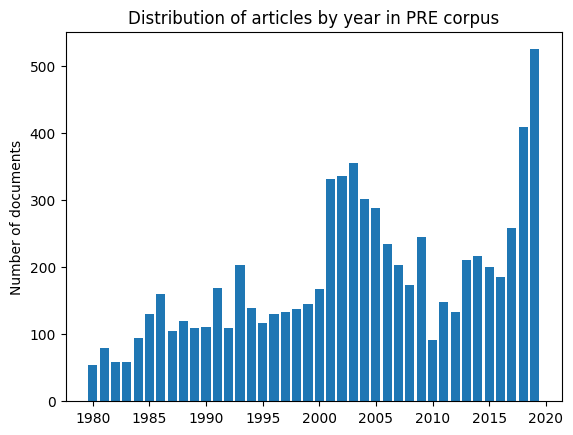

In [8]:
plt.bar(x_year, height=y_freq)
plt.ylabel('Number of documents')
plt.title('Distribution of articles by year in PRE corpus')
plt.show()

In [9]:
for doc in post_corpus:
    try:
        pubdate = doc['pubdate']
        year = pd.to_datetime(pubdate).year
        years.append(year)
    except:
        print(f'ERROR - pubdate value: {pubdate}')
        print(doc)

In [10]:
year_dist = Counter(years)
print(f'2020 has {year_dist[2020]} articles')
print(f'2021 has {year_dist[2021]} articles')

2020 has 3956 articles
2021 has 1000 articles


In [11]:
x_year, y_freq = zip(*year_dist.most_common())

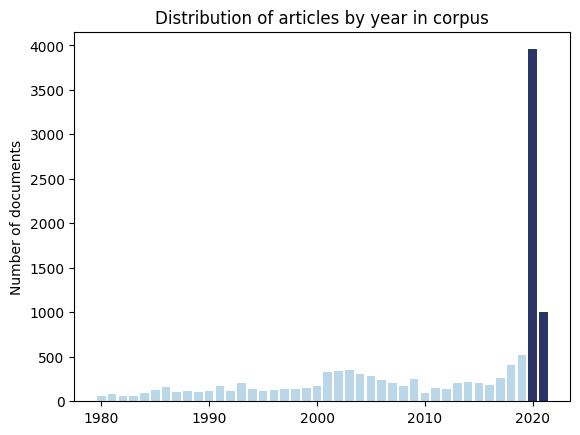

In [12]:
# update graph and color code by delimiting factor (beginning of covid pandemic)
bar_colors = ['#2B3467' if year in (2020,2021) else '#BAD7E9' for year in x_year]

plt.bar(x_year, height=y_freq, color=bar_colors)
plt.ylabel('Number of documents')
plt.title('Distribution of articles by year in corpus')
plt.show()

### Example: Find articles with `vaccin*` in the title

* Loop over each article in `pre_corpus` and `post_corpus`
    - Note can use `pre_corpus + post_corpus` to create a single list of articles
    
* Use a regexp search for string `vaccin` in any case
    - Note could do this with just the regular `str` functions with:
        ```
        match = title.lower().count('vaccin')
        ```
* Add matching article dictionaries to the list

In [13]:
vax_in_title = []
for article in pre_corpus + post_corpus:
    title = article['title']
    
    match = re.search('vaccin', title, re.I)
    
    if match:
        vax_in_title.append(article)

In [14]:
print(f'{len(vax_in_title)} articles mention vaccines.')


1887 articles mention vaccines.


In [15]:
# look at first 100 hits

for t in vax_in_title[:100]:
    print(f"- {t['title']}")

- BACTERIA WITH NEW GENES MAKE A FLU VACCINE
- FLU VACCINATIONS ARE URGED FOR THOSE IN HIGH-RISK GROUP
- Rabies Vaccinations for Cats Are Urged by Health Officials
- Doctors Asked to Give 2d Dose of Measles Vaccine
- Salk Says Tests of Vaccine Show Halt of AIDS Infection in Chimps
- Lyme Disease Vaccine In Testing
- Victory for Vaccine Makers
- To Avoid Measles: A Vaccination Guide
- Hepatitis Case Spurs Pennsylvania Vaccine Drive
- Salk Team Expands AIDS Vaccine Study - Correction Appended
- RESULTS OF HEPATITIS VACCINE ENCOURAGE HEALTH OFFICIALS
- A HERPES VACCINE EFFECTIVE IN MICE
- NEW YORK STATE WEIGHS VENTURE TO MARKET VACCINE
- Dr. William Bradford; Vaccination Developer
- NEW FLU VACCINE A SUCCESS IN TESTS
- THE NEW AGE OF VACCINES
- VACCINE LIABILITY THREATENS SUPPLIES
- MALARIA VACCINE IS NEAR, U.S. HEALTH OFFICIALS SAY
- CHIMPANZEES INFECTED WITH AIDS IN A STEP TOWARD VACCINE
- Hepatitis Vaccine Proves Effective
- EXPERTS PREDICT ALMOST EVERY CHILD ON EARTH WILL BE VACCINATE

### EDA: Getting basic type and token stats for corpora

* Easy way to do this is to create two frequency lists with Counters

* Same steps as always:
    1. loop over all articles
        - get body (and title?)
        - normalize and tokenize
        - update Counter with tokens
    2. use Counter object to get type and token count

In [16]:
def tokenize(text, lowercase=False, strip_chars=''):
    '''create a list of tokens from a string by splitting on whitespace and applying optional normalization 
    
    Args:
        text        -- a string object containing the text to be tokenized
        lowercase   -- should text string be normalized as lowercase (default: False)
        strip_chars -- a string indicating characters to strip out of text, e.g. punctuation (default: empty string) 
        
    Return:
        A list of tokens
    '''
    
    # create a replacement dictionary from the
    # string of characters in the **strip_chars**
    rdict = str.maketrans('','',strip_chars)
    
    if lowercase:
        text = text.lower()
    
    tokens = text.translate(rdict).split()
    
    return tokens

In [17]:
pre_freq_dist = Counter()
post_freq_dist = Counter()

combined_corpus = pre_corpus + post_corpus
doc_cnt = len(combined_corpus)

for cnt,article in enumerate(combined_corpus):
    
    # give some processing feedback as function takes a minute
    if cnt % 500 == 0:
        print(f'Processed {cnt} of {doc_cnt}...')
    
    # combine title and body text
    text = f"{article['title']}\n\n{article['body']}"
    
    # some normalization
    text = text.replace('’',"'")
    
    # here we use the simple tokenize function from class but could use an nltk.tokenizer
    tokens = tokenize(text, lowercase=True, strip_chars=REMOVE_CHARS)
    
    year = pd.to_datetime(article['pubdate']).year
    
    if year<2020:
        pre_freq_dist.update(tokens)
    else:
        post_freq_dist.update(tokens)

Processed 0 of 12334...
Processed 500 of 12334...
Processed 1000 of 12334...
Processed 1500 of 12334...
Processed 2000 of 12334...
Processed 2500 of 12334...
Processed 3000 of 12334...
Processed 3500 of 12334...
Processed 4000 of 12334...
Processed 4500 of 12334...
Processed 5000 of 12334...
Processed 5500 of 12334...
Processed 6000 of 12334...
Processed 6500 of 12334...
Processed 7000 of 12334...
Processed 7500 of 12334...
Processed 8000 of 12334...
Processed 8500 of 12334...
Processed 9000 of 12334...
Processed 9500 of 12334...
Processed 10000 of 12334...
Processed 10500 of 12334...
Processed 11000 of 12334...
Processed 11500 of 12334...
Processed 12000 of 12334...


In [18]:
print(f'Pre-corpus has {len(pre_freq_dist)} TYPES and {sum(pre_freq_dist.values())} TOKENS')
print(f'\nPost-corpus has {len(post_freq_dist)} TYPES and {sum(post_freq_dist.values())} TOKENS')

Pre-corpus has 130279 TYPES and 7210524 TOKENS

Post-corpus has 95705 TYPES and 7578859 TOKENS


* Length of counter is the number of TYPES
* Sum of the values of the counter is the number of TOKENS
Thus: even though you have more articles in pre-corpus token count is more in the post-corpus

### EDA: Keyness analysis

* Using the two frequency lists (`pre_freq_dist` and `post_freq_dist`) look at characteristic (i.e. used much more frequently) words in PRE vs POST corpus

In [19]:
def log_likelihood(item_A_freq, corpus_A_size, item_B_freq, corpus_B_size):
    '''
    
    '''
    E1 = corpus_A_size*(item_A_freq+item_B_freq) / (corpus_A_size+corpus_B_size)
    E2 = corpus_B_size*(item_A_freq+item_B_freq) / (corpus_A_size+corpus_B_size)

    G2 = 2*((item_A_freq*math.log(item_A_freq/E1)) + (item_B_freq*math.log(item_B_freq/E2)))
    
    sign = 1 if (item_A_freq / corpus_A_size) >= (item_B_freq / corpus_B_size) else -1
    
    return sign*G2

def calculate_keyness(fdist1, fdist2, fthreshold=5, keyness_threshold=6.6, top=100, print_table=True):
    '''
    '''
    
    c1size = sum(fdist1.values())
    c2size = sum(fdist2.values())

    
    kdata = []
    
    for item, freq in fdist1.items():
        if freq<fthreshold:
            continue
            
        ref_freq = fdist2.get(item,0)
        
        if ref_freq<fthreshold:
            continue
        
        
        keyness = log_likelihood(freq, c1size, ref_freq, c2size)
        
        row = {'item': item, 'freq': freq, 'ref_freq': ref_freq, 'keyness': keyness}
        
        kdata.append(row)
        
    
    kdf = pd.DataFrame(kdata)[['item', 'freq', 'ref_freq', 'keyness']]
    
    kdf=kdf.sort_values('keyness', ascending=False)
    
    if not print_table:
        return kdf[:top]
    
    template = "{: <25}{: <10}{: <10}{:0.3f}"
    
    header = "{: <25}{: <10}{: <10}{}".format('WORD', 'Corpus A', 'Corpus B', 'Keyness')
    
    print("{}\n{}".format(header, "="*len(header)))
    
    for item, freq, ref_freq, keyness in kdf[:top].values:
        print(template.format(item, freq, ref_freq, keyness))

In [20]:
print('pre vs post')
calculate_keyness(pre_freq_dist, post_freq_dist)

pre vs post
WORD                     Corpus A  Corpus B  Keyness
aids                     8969      302       10627.604
flu                      8925      1796      5533.905
disease                  13894     5139      4630.823
children                 10747     3604      4083.736
anthrax                  2910      27        3910.029
smallpox                 3307      168       3630.300
dr                       23486     13455     3281.006
measles                  3910      472       3254.019
polio                    3097      273       2919.130
cancer                   3150      476       2342.585
bush                     2708      328       2250.248
years                    10360     5067      2126.723
research                 7433      3041      2125.153
rabies                   1482      14        1989.291
a1                       1982      159       1927.481
hepatitis                1677      68        1925.693
hiv                      2359      327       1836.796
drugs           

In [21]:
print('post vs pre')
calculate_keyness(post_freq_dist, pre_freq_dist)

post vs pre
WORD                     Corpus A  Corpus B  Keyness
coronavirus              21154     106       27101.863
trump                    17028     1889      13194.707
pandemic                 14630     1239      12644.100
biden                    8827      156       10452.774
masks                    4101      220       4060.749
mr                       33241     18215     3735.747
trump's                  4310      539       3153.377
restrictions             3570      358       2890.371
times                    12003     4941      2693.764
biden's                  2072      27        2520.517
mask                     2396      100       2507.956
economy                  4903      1061      2495.514
reopen                   2178      63        2428.478
distancing               1846      9         2367.338
reopening                1938      28        2337.830
on                       66506     47850     2198.673
businesses               3175      479       2094.662
pfizer       

#### Getting keyness results as a data frame

* The `calculate_keyness` function will also return a Pandas data frame if you set `print_table` to `False`

In [22]:
keyness_df = calculate_keyness(pre_freq_dist, post_freq_dist, 
                               keyness_threshold=0, top=None, print_table=False)


In [23]:
keyness_df.shape

(25230, 4)

In [24]:
keyness_df

,item,freq,ref_freq,keyness
9348,aids,8969,302,10627.603875
72,flu,8925,1796,5533.904613
93,disease,13894,5139,4630.823100
374,children,10747,3604,4083.736207
3453,anthrax,2910,27,3910.029298
...,...,...,...,...
11459,masks,220,4101,-4060.749329
18524,biden,156,8827,-10452.773917
4934,pandemic,1239,14630,-12644.099938
15551,trump,1889,17028,-13194.707285


We can create a list of items to look up to get a filtered table

In [25]:
words_to_lookup = ['flu', 'measles', 'smallpox', 'shingles',  'covid', 'coronavirus', 'death', 'mumps', 'autism',
                   'fight', 'battle', 'wave', 'variant', 'shot', 'vaccine', 'vaccination', 'mandate', 'heart', 'myocarditis']
item_filter = keyness_df['item'].isin(words_to_lookup)
keyness_df[item_filter]

,item,freq,ref_freq,keyness
72,flu,8925,1796,5533.904613
930,smallpox,3307,168,3630.299805
874,measles,3910,472,3254.019018
21436,autism,1008,103,899.881973
37,vaccination,3977,2495,420.238004
875,mumps,456,44,416.097714
1409,heart,1398,631,336.745253
12564,shingles,365,41,313.508649
597,shot,1706,1449,35.719508
4744,battle,651,534,18.135059


* The fact that vaccine comes out with a keyness value near to 0 is a good validity check here!
* Our goal was to build two comparable corpora focused on 'vaccine'. So we'd hope to see an near equal number of instances.

* Can also use the `show_keyitems` plot function to display the top `n` items that are key in each corpus
    * Note the corpus B go in descending order. Font size relative to keyness value

In [26]:
def show_keyitems(df, n=20, c1='red', c2='blue', corpusA='corpus A', corpusB='corpus B'):
    '''plot  top/bottom n items from a keyness analysis table
    
    Args:
        df - a data frame created by calculated_keyness with cols: item, keyness
        num - the number of top and bottom ranked items to include
        c1/c2 - color for the bars
    
    Returns:
        HTML string containing two column table
    '''
   
    template = '''
        <div style=' float:left; width: 40%; text-align: center'>
        <h3>{}</h3>
        {}</div>
       <div style='width: 40%; padding-left: 20px; float: left; '>
       <h3 style="text-align: center">{}</h3>
        {}</div>
    '''


    idiv = '''
            <span style="font-size: {}px; color: {}; margin-bottom: 2px;  
            margin: 4px; padding: 2px; background-color: #f7f7f7; border-radius: 6px">
            {}</span>
            '''
    
    top = df[['item', 'keyness']].head(n).values
    bottom = df[['item', 'keyness']].tail(n).values

    top_str = '\n'.join([idiv.format(5*math.log(kness), c1, item) for size, (item, kness) in enumerate(top,1)])
    bottom_str = '\n'.join([idiv.format(5*math.log(abs(kness)), c2, item) for size, (item, kness) in enumerate(bottom,1)])
    
    
    display(HTML(
        template.format(corpusA,top_str, corpusB, bottom_str)
    ))

In [27]:
show_keyitems(keyness_df, 
              n=50,
              corpusA='Pre-2020', 
              corpusB="2020+")

### EDA: Getting vaccine n-grams

* Process each article
    - normalize and tokenize
    - create ngrams (2- to 5-)
    - filter for those containing string "vaccin`

In [28]:
def get_ngram_tokens(tokens, n=1):
    
    if n<2 or n>len(tokens):
        return tokens
    
    new_tokens = []
    
    for i in range(len(tokens)-n+1):
        new_tokens.append(" ".join(tokens[i:i+n]))
        
    return new_tokens

In [29]:
pre_vax_ngrams = Counter()
doc_cnt = len(pre_corpus)

# do for pre_corpus
for cnt,article in enumerate(pre_corpus):
    
    # give some processing feedback as function takes a minute
    if cnt % 500 == 0:
        print(f'Processed {cnt} of {doc_cnt}...')
    
    # combine title and body text
    text = f"{article['title']}\n\n{article['body']}"
    
    # here we use the simple tokenize function from class but could use an nltk.tokenizer
    tokens = tokenize(text, lowercase=True, strip_chars=REMOVE_CHARS)
    
    # get token lists from 2- to 5- grams
    for n in range(2,6):
        ngrams = get_ngram_tokens(tokens,n)
        
        # filter ngram list so it must contain 'vaccin'
        vax_ngrams = [ng for ng in ngrams if ng.count('vaccin')>0]
        
        # add filtered ngrams to Counter
        pre_vax_ngrams.update(vax_ngrams)
        
print(f'The top 5 most common pre-COVID19 vax ngrams are: {pre_vax_ngrams.most_common(5)}')

Processed 0 of 7378...


Processed 500 of 7378...
Processed 1000 of 7378...
Processed 1500 of 7378...
Processed 2000 of 7378...
Processed 2500 of 7378...
Processed 3000 of 7378...
Processed 3500 of 7378...
Processed 4000 of 7378...
Processed 4500 of 7378...
Processed 5000 of 7378...
Processed 5500 of 7378...
Processed 6000 of 7378...
Processed 6500 of 7378...
Processed 7000 of 7378...
The top 5 most common pre-COVID19 vax ngrams are: [('the vaccine', 5525), ('a vaccine', 2309), ('vaccine is', 1179), ('flu vaccine', 1116), ('vaccine for', 941)]


In [30]:
post_vax_ngrams = Counter()
doc_cnt = len(post_corpus)

# do for post_corpus
for cnt, article in enumerate(post_corpus):
    
    
    # give some processing feedback as function takes a minute
    if cnt % 500 == 0:
        print(f'Processed {cnt} of {doc_cnt}...')
    
    # combine title and body text
    text = f"{article['title']}\n\n{article['body']}"
    
    # here we use the simple tokenize function from class but could use an nltk.tokenizer
    tokens = tokenize(text, lowercase=True, strip_chars=REMOVE_CHARS)
    
    # get token lists from 2- to 5- grams
    for n in range(2,6):
        ngrams = get_ngram_tokens(tokens,n)
        
        # filter ngram list so it must contain 'vaccin'
        vax_ngrams = [ng for ng in ngrams if ng.count('vaccin')>0]
        
        # add filtered ngrams to Counter
        post_vax_ngrams.update(vax_ngrams)
        
print(f'The top 5 most common post-COVID19 vax ngrams are: {post_vax_ngrams.most_common(5)}')

Processed 0 of 4956...
Processed 500 of 4956...
Processed 1000 of 4956...
Processed 1500 of 4956...
Processed 2000 of 4956...
Processed 2500 of 4956...
Processed 3000 of 4956...
Processed 3500 of 4956...
Processed 4000 of 4956...
Processed 4500 of 4956...
The top 5 most common post-COVID19 vax ngrams are: [('the vaccine', 4889), ('a vaccine', 4490), ('coronavirus vaccine', 1994), ('vaccine is', 1002), ('a coronavirus vaccine', 941)]


* To compare these two lists we can use the `log_likelihood` function that takes the frequency of an item in two corpora and the size of those corpora and returns a value indicating if the relatively frequency difference is notable.

In [31]:
# get a unique list of the VAX ngrams
all_vax_ngrams = set(list(pre_vax_ngrams.keys()) + list(post_vax_ngrams.keys()))

pre_token_cnt = sum(pre_freq_dist.values())
post_token_cnt = sum(post_freq_dist.values())

In [32]:
vax_key_data = []

for vax_ngram in all_vax_ngrams:
    pre_freq = pre_vax_ngrams.get(vax_ngram)
    post_freq = post_vax_ngrams.get(vax_ngram)

    # can only calculate LL if have a frequency for both pre and post
    if pre_freq is None or post_freq is None:
        continue
        
    # get Log-likelihood value
    LL_val = log_likelihood(pre_freq, pre_token_cnt,
                                post_freq, post_token_cnt)
    
    # add item values to a list
    vax_key_data.append((vax_ngram, pre_freq, post_freq, LL_val))

# convert into a Pandas data frame
vax_key_df = pd.DataFrame(vax_key_data, columns = ('ngram', 'pre_freq', 'post_freq', 'keyness'))

* Pandas data frames for quicker sorting and filtering

* e.g. get the top 50 items sorted from smallest to highest (default order). This gets those items that are characteristic of corpus B (post) compared to corpus A (pre)

In [33]:
vax_key_df.sort_values('keyness').head(20)

,ngram,pre_freq,post_freq,keyness
402,coronavirus vaccine,1,1994,-2650.405467
3671,a coronavirus vaccine,1,941,-1243.947049
7591,coronavirus vaccines,1,614,-807.570709
5417,a vaccine,2309,4490,-607.707193
12370,vaccine rollout,4,350,-429.911120
2616,its vaccine,80,556,-377.169052
10959,pfizer vaccine,4,302,-366.903461
15657,vaccine distribution,17,333,-333.675688
16173,the pfizer vaccine,4,262,-314.548357
7725,the vaccine rollout,2,174,-213.641259


* There are also the `nlargest` and `nsmallest` functions that do this in one step


* Top 20 items sorted by keyness - so characteristic of corpus A (pre) compared to corpus B (post)

In [34]:
vax_key_df.nlargest(20, 'keyness')

,ngram,pre_freq,post_freq,keyness
18844,flu vaccine,1116,173,818.165532
19193,smallpox vaccine,521,4,706.901484
15233,aids vaccine,493,2,684.947419
6543,anthrax vaccine,301,2,411.062571
13514,vaccine against,591,118,368.528932
11232,polio vaccine,390,61,284.467237
11343,of flu vaccine,191,6,228.726407
5057,vaccinated against,385,84,224.568380
6656,influenza vaccine,209,13,218.655658
8280,measles vaccine,234,23,212.047258


* Also probably want to apply somekind of minimum frequency threshold, e.g. only look at items occurring 10+ times

In [35]:
freq_filter = (vax_key_df['pre_freq']>10) & (vax_key_df['post_freq'] > 10)

vax_key_df[freq_filter].nlargest(20, 'keyness')

,ngram,pre_freq,post_freq,keyness
18844,flu vaccine,1116,173,818.165532
13514,vaccine against,591,118,368.528932
11232,polio vaccine,390,61,284.467237
5057,vaccinated against,385,84,224.568380
6656,influenza vaccine,209,13,218.655658
8280,measles vaccine,234,23,212.047258
8018,new vaccine,461,139,198.652435
14088,the new vaccine,207,28,163.186792
13792,a vaccine against,266,63,145.057661
4689,vaccines against,273,69,140.556117


In [36]:
vax_key_df[freq_filter].nsmallest(20, 'keyness')

,ngram,pre_freq,post_freq,keyness
5417,a vaccine,2309,4490,-607.707193
2616,its vaccine,80,556,-377.169052
15657,vaccine distribution,17,333,-333.675688
19531,vaccine candidates,21,231,-194.474785
18833,vaccine doses,58,287,-154.585133
4294,for a vaccine,121,371,-121.007023
4573,a vaccine is,95,317,-115.405735
14576,the vaccines,468,894,-115.125848
17851,their vaccines,18,152,-114.241096
6327,that a vaccine,101,326,-113.820790
